In [2]:
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from PIL import Image
import glob
import shutil
from skimage import io
import cv2

In [3]:
def Classes_and_velocity(path):
    classes =[]
    for dirname, _, filenames in os.walk(path):
        classname = dirname.replace(path, '')
        number = 0
        for filename in filenames:
            number = number+ 1
        classes.append((classname[1:],number))
    
    classes.pop(0)

    return classes

def Image_DS_Split(loadpath,savepath,train_to_val_ratio = 0.8,trainval_to_test_ratio = 0.8,batchsize = 32,img_height =180,img_width = 180):
    DataTable =[]
    classes = Classes_and_velocity(loadpath)
    for dirname, _, filenames in os.walk(loadpath):
        classname = dirname.replace(loadpath, '')
        filenamestable = []
        for filename in filenames:
            filenamestable.append((classname[1:],filename))
            #print(os.path.join(dirname, filename))
            #print (filename)
        DataTable.append(filenamestable)
    DataTable.pop(0)
    import random
    Train_val_img_names = []
    for idex,filenames in enumerate(DataTable): 
        l = classes[idex][1] 
        number_of_files = int(l*trainval_to_test_ratio)
        Train_val_img_names.append(random.sample(filenames, number_of_files))

    
    for index in range (len(DataTable)):
        for element in Train_val_img_names[index]:
            DataTable[index].remove(element)

    
    DataTable = np.array(DataTable,dtype = object)
    DataTable = DataTable.flatten()
    
    Train_val_img_names = np.array(Train_val_img_names, dtype = object)
    Train_val_img_names = Train_val_img_names.flatten()



    def create_new_folder(parent_dir,new_folder_name):
        path = os.path.join(parent_dir, new_folder_name)
        os.mkdir(path)
    
    def path_create(read_path,classname,save_path,filename):
        final_readpath = os.path.join(read_path, classname,filename)
        final_savepath = os.path.join(save_path, classname)
        return final_readpath,final_savepath
    
    create_new_folder(savepath,new_folder_name= 'train_val')
    create_new_folder(savepath,new_folder_name= 'test')
    sp1 = os.path.join(savepath, 'train_val')
    sp2 = os.path.join(savepath,'test')

    for i, dat in enumerate(classes):
        create_new_folder(sp1,dat[0])
        create_new_folder(sp2,dat[0])
    

    for j in range(len (DataTable)):
        for i, data in enumerate(DataTable[j]):
            x,y = path_create(loadpath,data[0],sp2,data[1])
            copy_relocating_image(x,y)
    
    for j in range(len (Train_val_img_names)):
        for i, data in enumerate(Train_val_img_names[j]):
            x,y = path_create(loadpath,data[0],sp1,data[1])
            copy_relocating_image(x,y)  

    test_ds = tf.keras.utils.image_dataset_from_directory( sp2, validation_split= 0.999999, subset="validation", seed=123, image_size=(img_height, img_width),
    batch_size=batchsize)
    train_ds = tf.keras.utils.image_dataset_from_directory( sp1, validation_split= (1 -train_to_val_ratio), subset="training", seed=123, image_size=(img_height, img_width),
    batch_size=batchsize)
    val_ds = tf.keras.utils.image_dataset_from_directory( sp1, validation_split= (1 -train_to_val_ratio), subset="validation", seed=123, image_size=(img_height, img_width),
    batch_size=batchsize)
    

    return train_ds , val_ds,test_ds,classes

        

        
def copy_relocating_image(readpath,save_path):
    for jpgfile in glob.iglob(readpath):
        shutil.copy(jpgfile, save_path)
    


In [4]:
batch_size = 32
img_height = 180
img_width = 180


In [5]:
train_ds , val_ds,test_ds,classes =Image_DS_Split(r'data\beer_labels',r'data',0.8,0.4,batchsize=batch_size,img_height=img_height, img_width = img_width)

Found 4868 files belonging to 100 classes.
Using 4867 files for validation.
Found 3139 files belonging to 100 classes.
Using 2512 files for training.
Found 3139 files belonging to 100 classes.
Using 627 files for validation.


In [6]:
class_names = train_ds.class_names

In [7]:
num_classes = len (class_names)

In [12]:
model = Sequential([
  layers.Rescaling(1./255),
  layers.Conv2D(5, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(10, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.1),
  layers.Dense(num_classes,activation='sigmoid')
])


In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


In [14]:
epochs = 9
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/9
79/79 [==============================] - 15s 183ms/step - loss: 4.5747 - accuracy: 0.0215 - val_loss: 4.4349 - val_accuracy: 0.0144
Epoch 2/9
79/79 [==============================] - 15s 184ms/step - loss: 3.9871 - accuracy: 0.1146 - val_loss: 3.4575 - val_accuracy: 0.1898
Epoch 3/9
79/79 [==============================] - 15s 186ms/step - loss: 2.8188 - accuracy: 0.3201 - val_loss: 2.4350 - val_accuracy: 0.3780
Epoch 4/9
79/79 [==============================] - 15s 185ms/step - loss: 1.9099 - accuracy: 0.5008 - val_loss: 1.8757 - val_accuracy: 0.5024
Epoch 5/9
79/79 [==============================] - 15s 187ms/step - loss: 1.3853 - accuracy: 0.6270 - val_loss: 1.5077 - val_accuracy: 0.5885
Epoch 6/9
79/79 [==============================] - 15s 193ms/step - loss: 1.0495 - accuracy: 0.7174 - val_loss: 1.3431 - val_accuracy: 0.6348
Epoch 7/9
79/79 [==============================] - 15s 185ms/step - loss: 0.8284 - accuracy: 0.7731 - val_loss: 1.1954 - val_accuracy: 0.6778
Epoch 

In [15]:
test_loss, test_acc = model.evaluate(test_ds,verbose=2)
print(f'\nTest accuracy: {round(100 * test_acc, 2)}')

153/153 - 9s - loss: 1.0594 - accuracy: 0.7078 - 9s/epoch - 57ms/step

Test accuracy: 70.78


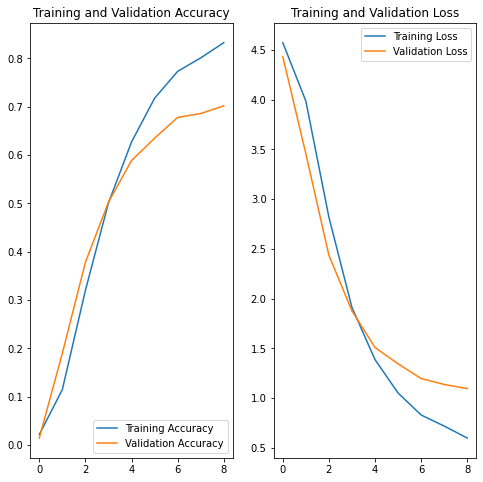

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Jak widzimy po fukcji dokładności, dla zbioru treningowego dokładność jest znacząco większa niz dla zbioru validacyjnego - to znaczy model się przeucza. Żeby to poprawić powinniśmy zwiększyć dropout. Można też użyć agumentacji tj przekształconych tych samych zdjeć w celu zwiększenia zbioru treningowego (chociaż nie musi w tym przypadku to być aż tak potrzebne ponieważ mamy ponad 3000 zdjeć na 100 klas) 

Kolejną rzeczą która rzuca sie w oczy to że fukcja straty ciągle maleje - to znaczy można model dalej trenować by osiągnąć większą dokładność


In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 180, 5)       140       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 90, 90, 5)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 10)        460       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 45, 45, 10)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 20250)            

In [18]:
def test_model_by_img_class(class_path,mod,img_size,classname,class_names):
    for dirname, _, filenames in os.walk(class_path):
        correct_pred = 0
        num_of_all_pred = num_of_all_pred = len(filenames)
        for filename in filenames:
            path = os.path.join(class_path, filename)
            img = tf.keras.utils.load_img(path, target_size=img_size )

            img_array = tf.keras.utils.img_to_array(img)
            img_array = tf.expand_dims(img_array, 0)
            predictions = mod.predict(img_array)
            score = tf.nn.softmax(predictions[0])

            if (class_names[np.argmax(score)] ==classname) :
                correct_pred = correct_pred+1
        
        print("Class: {} has accurancy: {}".format(classname, round (correct_pred/num_of_all_pred * 100,2)))
        break

            
    return (classname,correct_pred/num_of_all_pred * 100)
    


In [19]:
class_names =test_ds.class_names

In [20]:
class_pred_results = []
for i,c in enumerate (classes):
    path = os.path.join(r'data\test', c[0])
    class_pred_results.append( test_model_by_img_class(path,model,(180,180),c[0], class_names))
    
    

Class: 5901549250329 has accurancy: 53.57
Class: 5901549250756 has accurancy: 95.24
Class: 5902448150178 has accurancy: 80.95
Class: 5902528052347 has accurancy: 88.1
Class: 5902528442230 has accurancy: 59.52
Class: 5902528443251 has accurancy: 37.5
Class: 5902528462337 has accurancy: 21.43
Class: 5902528473449 has accurancy: 29.41
Class: 5902528523311 has accurancy: 85.71
Class: 5902528573354 has accurancy: 80.95
Class: 5902528999994 has accurancy: 52.38
Class: 5902627011481 has accurancy: 64.29
Class: 5902705000871 has accurancy: 45.24
Class: 5902705001045 has accurancy: 92.86
Class: 5902931900112 has accurancy: 87.5
Class: 5902931900310 has accurancy: 47.83
Class: 5902931900419 has accurancy: 62.5
Class: 5903031401516 has accurancy: 74.51
Class: 5903111989811 has accurancy: 35.71
Class: 5903111989835 has accurancy: 62.75
Class: 5903111989873 has accurancy: 69.05
Class: 5903240620142 has accurancy: 96.43
Class: 5903240674145 has accurancy: 67.57
Class: 5903240674527 has accurancy: 78

In [21]:
class_pred_results.sort(key=lambda x:x[1])


20 klas z najgorszym wynikiem oraz odpowiadający im % poprawnych odpowiedzi:

In [22]:
class_pred_results[:30]

[('5906874605004', 14.285714285714285),
 ('5906874605059', 16.666666666666664),
 ('5902528462337', 21.428571428571427),
 ('5906874605011', 26.190476190476193),
 ('5906874605042', 26.190476190476193),
 ('5904730284561', 27.450980392156865),
 ('5905669542722', 28.57142857142857),
 ('5902528473449', 29.411764705882355),
 ('5904730284028', 30.952380952380953),
 ('5906874605066', 30.952380952380953),
 ('5905279965102', 33.33333333333333),
 ('5903111989811', 35.714285714285715),
 ('5906874605035', 35.714285714285715),
 ('5902528443251', 37.5),
 ('5904730284004', 37.83783783783784),
 ('5906874605073', 40.54054054054054),
 ('5905279965201', 42.857142857142854),
 ('5902705000871', 45.23809523809524),
 ('5906874605028', 45.23809523809524),
 ('5904730284660', 45.94594594594595),
 ('5905669086233', 46.42857142857143),
 ('5905669683005', 47.61904761904761),
 ('5905669683012', 47.61904761904761),
 ('5907431705083', 47.61904761904761),
 ('5902931900310', 47.82608695652174),
 ('5905669086240', 48.2142

In [31]:
#code borrowed from: https://gist.github.com/zollinger/1722663

from PIL import Image, ImageDraw
import argparse
import sys

def get_colors(image_file, numcolors=10, resize=150):
    # Resize image to speed up processing
    img = Image.open(image_file)
    img = img.copy()
    img.thumbnail((resize, resize))

    # Reduce to palette
    paletted = img.convert('P', palette=Image.ADAPTIVE, colors=numcolors)

    # Find dominant colors
    palette = paletted.getpalette()
    color_counts = sorted(paletted.getcolors(), reverse=True)
    colors = list()
    for i in range(numcolors):
        palette_index = color_counts[i][1]
        dominant_color = palette[palette_index*3:palette_index*3+3]
        colors.append(tuple(dominant_color))

    return colors

def save_palette(colors, swatchsize=20, outfile="palette.png" ):
    num_colors = len(colors)
    palette = Image.new('RGB', (swatchsize*num_colors, swatchsize))
    draw = ImageDraw.Draw(palette)

    posx = 0
    for color in colors:
        draw.rectangle([posx, 0, posx+swatchsize, swatchsize], fill=color) 
        posx = posx + swatchsize

    del draw
    palette.save(outfile, "PNG")


In [33]:
def test_model_by_img_color(dir,mod,img_size,class_names):
    wrong_pred_colors = []
    total_pred = 0
    for dirname, _, filenames in os.walk(dir):
        for filename in filenames:
            total_pred = total_pred+1
            path = os.path.join(dirname,filename)

            img = tf.keras.utils.load_img(path, target_size=img_size )

            img_array = tf.keras.utils.img_to_array(img)
            img_array = tf.expand_dims(img_array, 0)
            predictions = mod.predict(img_array)
            score = tf.nn.softmax(predictions[0])

            classname = dirname.replace(dir, '')
            classname = classname[1:]
            
            if (class_names[np.argmax(score)] != classname):
                img_1 = io.imread(path)[:, :, :-1]
                avrg  = img_1.mean(axis=0).mean(axis=0)
                dominant = get_colors(path,resize=180)
                wrong_pred_colors.append((classname,avrg,dominant))
                print("Wrong predicted file: {}, accurancy so far: {}".format(filename,round ( (1 -(len(wrong_pred_colors)/total_pred)) * 100),2 ) )
                
        
        

            
    return wrong_pred_colors
    

In [34]:
wrong_pred_colors = test_model_by_img_color(r'data\test',model,(180,180),class_names = class_names)

Wrong predicted file: _0_9378199.jpg, accurancy so far: 0
Wrong predicted file: _10_9144125.jpg, accurancy so far: 0
Wrong predicted file: _16_6383614.jpg, accurancy so far: 25
Wrong predicted file: _1_4920351.jpg, accurancy so far: 20
Wrong predicted file: _23_6176503.jpg, accurancy so far: 44
Wrong predicted file: _26_9946897.jpg, accurancy so far: 45
Wrong predicted file: _27_32990.jpg, accurancy so far: 42
Wrong predicted file: _28_6936778.jpg, accurancy so far: 38
Wrong predicted file: _30_2741886.jpg, accurancy so far: 44
Wrong predicted file: _36_9639145.jpg, accurancy so far: 47
Wrong predicted file: _3_4693216.jpg, accurancy so far: 50
Wrong predicted file: _40_6778996.jpg, accurancy so far: 48
Wrong predicted file: _41_1176778.jpg, accurancy so far: 46
Wrong predicted file: _43_6892619.jpg, accurancy so far: 44
Wrong predicted file: _46_6553200.jpg, accurancy so far: 42
Wrong predicted file: _50_5165305.jpg, accurancy so far: 47
Wrong predicted file: _53_1385568.jpg, accuranc

Dzięki funkcji którą użyłem wyżej możemy powiązać "problematyczny" kolor z "problematycznymi" klasami w których wychodzą najgorsze wyniki i dla tych zdjęć zaimplementowac agumenacje w celu zwiększenia zbioru treningowego i zbalansowania modelu. 

Kolejną rzeczą którą można zrobić jest znalezienie współczynników koloru, który jest na zdjęciach w klasach. To znaczy można zobaczyć że niektóre zdjęcia są specjalnie robione przy innym świetle, zauważając to można zbalansować zbiór treningowy by odzwierciedlał każde naświetlenie. (raczej nie będę tego wykonywał ponieważ wydaje się to dosyć pracochłonne a i tak dosyć dużo jest w tym zadaniu zrobione)

Do zbioru treningowego mozna stworzyć więcej zdjęć o określonej jasności tak 